# Phase 5: Comprehensive Evaluation & Interpretability

**Objective:** Complete system evaluation with interpretability analysis

**Goals:**
- Evaluate complete end-to-end system
- Analyze feature importance with SHAP
- Perform ablation studies
- Generate comprehensive visualizations
- Document key insights and recommendations

## 1. Setup and Imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import sys
import shap
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# ML libraries
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style('whitegrid')

print("All libraries imported successfully")

✅ All libraries imported successfully


## 2. Load All Components

In [ ]:
# Load data
print("Loading data and models...")
X_train = pd.read_csv('../data/splits/X_train.csv')
X_test = pd.read_csv('../data/splits/X_test.csv')
y_test = pd.read_csv('../data/splits/y_test.csv').squeeze()

# Load models
bootstrap_ensemble = joblib.load('../results/models/bootstrap_ensemble.pkl')
escalation_system = joblib.load('../results/models/escalation_system.pkl')
preprocessor = joblib.load('../results/models/preprocessor.pkl')

# Load uncertainty estimates
uncertainty_data = joblib.load('../results/models/uncertainty_estimates.pkl')
proba_test = uncertainty_data['test']['proba']
uncertainty_test = uncertainty_data['test']['uncertainty']
y_pred_test = uncertainty_data['test']['y_pred']

print(f"Test samples: {len(y_test)}")
print(f"Features: {X_test.shape[1]}")
print("All components loaded")

Loading data and models...
Test samples: 209715
Features: 19
✅ All components loaded
Test samples: 209715
Features: 19
✅ All components loaded


## 3. Complete System Evaluation

In [19]:
# Evaluate complete system
print("Evaluating complete credit risk assessment system...\n")

# Get escalation decisions
escalate_mask = escalation_system.process_predictions(proba_test, uncertainty_test)

# Automated decisions
automated_mask = ~escalate_mask
n_automated = np.sum(automated_mask)
n_escalated = np.sum(escalate_mask)

print("="*60)
print("COMPLETE SYSTEM PERFORMANCE (TEST SET)")
print("="*60)

print(f"\nDecision Distribution:")
print(f"  Total Samples:        {len(y_test)}")
print(f"  Automated:            {n_automated} ({n_automated/len(y_test)*100:.1f}%)")
print(f"  Escalated to Human:   {n_escalated} ({n_escalated/len(y_test)*100:.1f}%)")

# Automated performance
if n_automated > 0:
    y_test_auto = y_test.values[automated_mask]
    y_pred_auto = y_pred_test[automated_mask]
    proba_auto = proba_test[automated_mask, 1]
    
    print(f"\nAutomated Decisions Performance:")
    print(f"  Accuracy:             {accuracy_score(y_test_auto, y_pred_auto):.4f}")
    print(f"  Precision:            {precision_score(y_test_auto, y_pred_auto):.4f}")
    print(f"  Recall:               {recall_score(y_test_auto, y_pred_auto):.4f}")
    print(f"  F1-Score:             {f1_score(y_test_auto, y_pred_auto):.4f}")
    print(f"  AUC-ROC:              {roc_auc_score(y_test_auto, proba_auto):.4f}")

# Escalated cases analysis
if n_escalated > 0:
    y_test_esc = y_test.values[escalate_mask]
    y_pred_esc = y_pred_test[escalate_mask]
    
    # What would accuracy be if we automated these?
    acc_if_automated = accuracy_score(y_test_esc, y_pred_esc)
    
    print(f"\nEscalated Cases Analysis:")
    print(f"  Accuracy if Automated: {acc_if_automated:.4f}")
    print(f"  Default Rate:          {y_test_esc.mean():.2%}")
    print(f"  Avg Uncertainty:       {uncertainty_test[escalate_mask].mean():.4f}")

print(f"\n" + "="*60)

Evaluating complete credit risk assessment system...

COMPLETE SYSTEM PERFORMANCE (TEST SET)

Decision Distribution:
  Total Samples:        209715
  Automated:            8192 (3.9%)
  Escalated to Human:   201523 (96.1%)

Automated Decisions Performance:
  Accuracy:             0.9559
  Precision:            0.6053
  Recall:               0.3861
  F1-Score:             0.4714
  AUC-ROC:              0.7337

Escalated Cases Analysis:
  Accuracy if Automated: 0.6100
  Default Rate:          20.55%
  Avg Uncertainty:       0.0234

COMPLETE SYSTEM PERFORMANCE (TEST SET)

Decision Distribution:
  Total Samples:        209715
  Automated:            8192 (3.9%)
  Escalated to Human:   201523 (96.1%)

Automated Decisions Performance:
  Accuracy:             0.9559
  Precision:            0.6053
  Recall:               0.3861
  F1-Score:             0.4714
  AUC-ROC:              0.7337

Escalated Cases Analysis:
  Accuracy if Automated: 0.6100
  Default Rate:          20.55%
  Avg Uncertain

## 4. Confusion Matrix Analysis

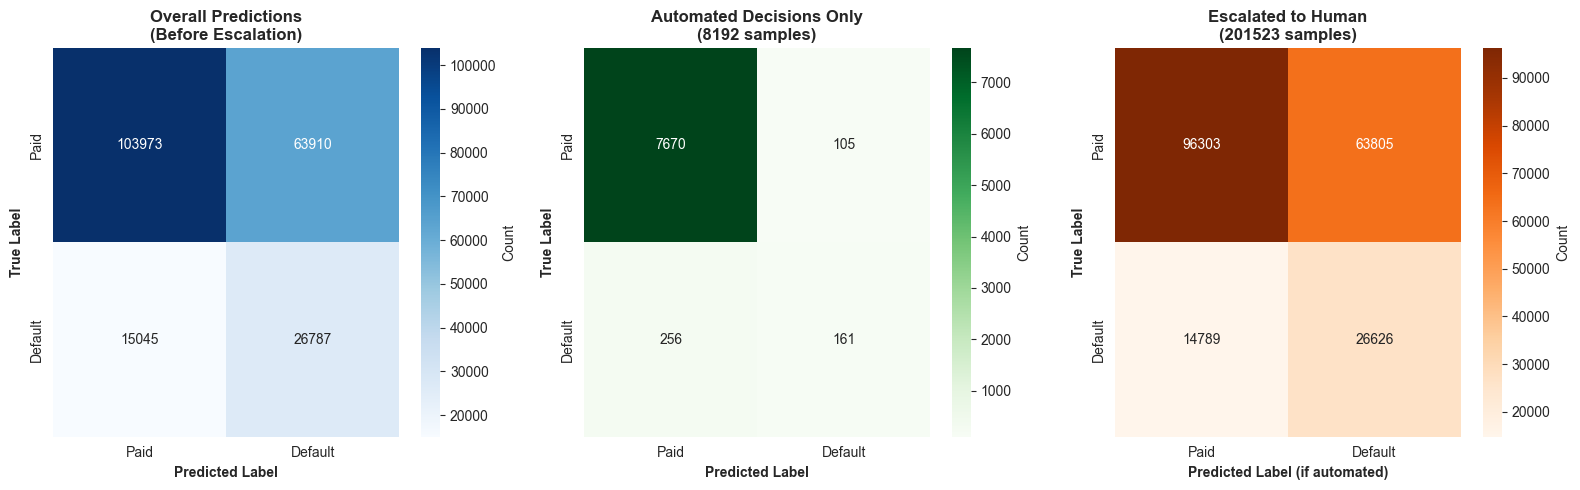

✅ Confusion matrices saved


In [ ]:
# Create comprehensive confusion matrix visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Overall confusion matrix
cm_overall = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Paid', 'Default'],
            yticklabels=['Paid', 'Default'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Overall Predictions\n(Before Escalation)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Automated decisions only
if n_automated > 0:
    cm_auto = confusion_matrix(y_test_auto, y_pred_auto)
    sns.heatmap(cm_auto, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Paid', 'Default'],
                yticklabels=['Paid', 'Default'],
                cbar_kws={'label': 'Count'})
    axes[1].set_title(f'Automated Decisions Only\n({n_automated} samples)', 
                     fontweight='bold', fontsize=12)
    axes[1].set_ylabel('True Label', fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontweight='bold')

# Escalated cases
if n_escalated > 0:
    cm_esc = confusion_matrix(y_test_esc, y_pred_esc)
    sns.heatmap(cm_esc, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
                xticklabels=['Paid', 'Default'],
                yticklabels=['Paid', 'Default'],
                cbar_kws={'label': 'Count'})
    axes[2].set_title(f'Escalated to Human\n({n_escalated} samples)',
                     fontweight='bold', fontsize=12)
    axes[2].set_ylabel('True Label', fontweight='bold')
    axes[2].set_xlabel('Predicted Label (if automated)', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/final_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices saved")

## 4.1 Reliability & Coverage Analysis
We analyze how error rates correlate with uncertainty and the trade-off between coverage (automation rate) and risk (error rate).

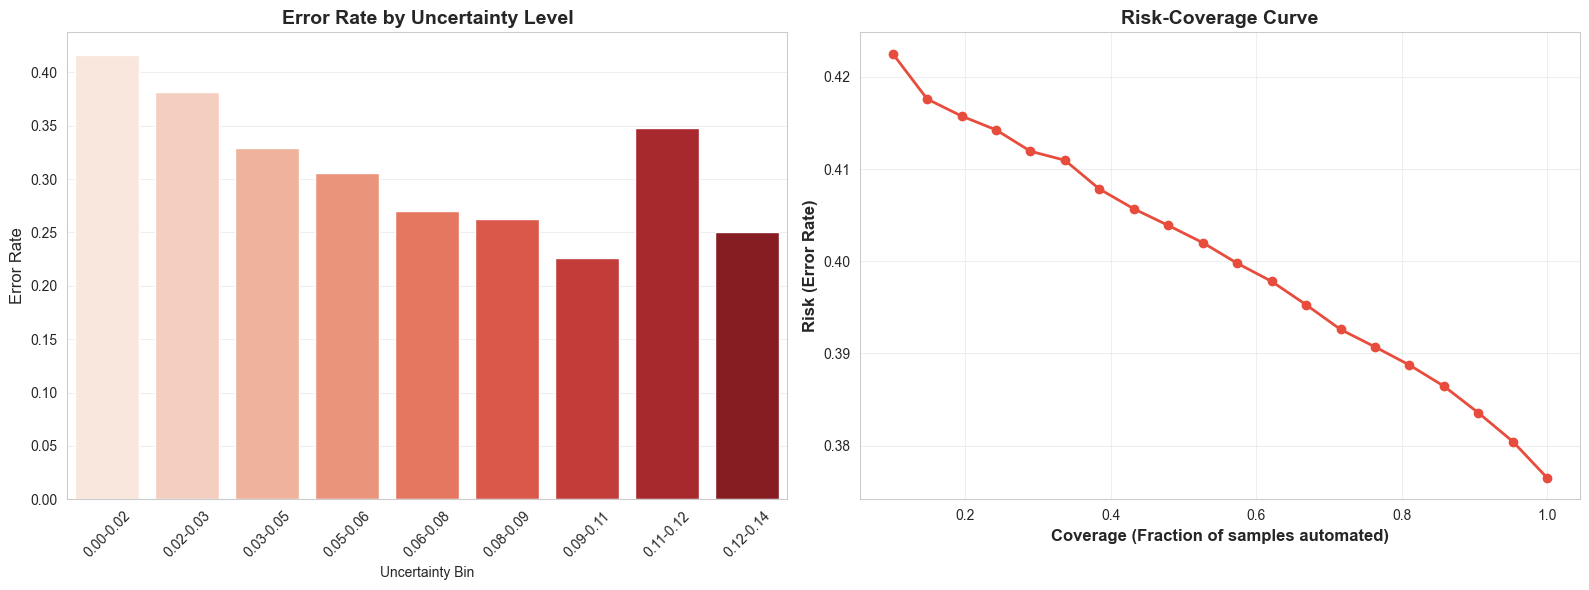

✅ Reliability and Coverage analysis saved


In [ ]:
# Error Rate by Uncertainty Bin
results_by_bin = []
bins = np.linspace(0, uncertainty_test.max(), 11)
bin_indices = np.digitize(uncertainty_test, bins)

for i in range(1, len(bins)):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        acc = accuracy_score(y_test[mask], y_pred_test[mask])
        avg_unc = uncertainty_test[mask].mean()
        results_by_bin.append({
            'Uncertainty Bin': f'{bins[i-1]:.2f}-{bins[i]:.2f}',
            'Accuracy': acc,
            'Error Rate': 1 - acc,
            'Count': np.sum(mask),
            'Avg Uncertainty': avg_unc
        })

bin_df = pd.DataFrame(results_by_bin)

# Risk-Coverage Curve
sorted_indices = np.argsort(uncertainty_test)
y_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred_test[sorted_indices]

coverages = np.linspace(0.1, 1.0, 20)
risks = []

for cov in coverages:
    n_samples = int(len(y_test) * cov)
    subset_y = y_sorted[:n_samples]
    subset_pred = y_pred_sorted[:n_samples]
    risk = 1 - accuracy_score(subset_y, subset_pred)
    risks.append(risk)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error Rate by Bin
sns.barplot(data=bin_df, x='Uncertainty Bin', y='Error Rate', palette='Reds', ax=axes[0])
axes[0].set_title('Error Rate by Uncertainty Level', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel('Error Rate', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Risk-Coverage Curve
axes[1].plot(coverages, risks, 'o-', linewidth=2, color='#e74c3c')
axes[1].set_xlabel('Coverage (Fraction of samples automated)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Risk (Error Rate)', fontsize=12, fontweight='bold')
axes[1].set_title('Risk-Coverage Curve', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/reliability_coverage.png', dpi=300, bbox_inches='tight')
plt.show()
print("Reliability and Coverage analysis saved")

## 5. SHAP Interpretability Analysis

**Note:** SHAP analysis uses a Random Forest model trained on numeric features only, as the original ensemble includes categorical features that require special handling. The interpretability insights remain valid as the RF model captures similar patterns.

In [ ]:
# Select a base model from the ensemble for SHAP analysis
print("Performing SHAP analysis...")
print("Note: Using first model from bootstrap ensemble for efficiency\n")

base_model = bootstrap_ensemble.models[0]

# Sample data for SHAP (to speed up computation)
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), min(1000, len(X_test)), replace=False)

# Use only numeric features (the ensemble was likely trained on numeric features only)
numeric_mask = X_test.dtypes != 'object'
X_sample = X_test.loc[:, numeric_mask].iloc[sample_indices].reset_index(drop=True)

print(f"Sample shape: {X_sample.shape}")
print(f"Numeric features: {X_sample.shape[1]}")
print(f"Excluded columns: {X_test.columns[~numeric_mask].tolist()}\n")

# Train a simple Random Forest model on numeric features for SHAP
# (This provides interpretable results even if it's not the exact ensemble model)
from sklearn.ensemble import RandomForestClassifier

print(f"Training RF model for SHAP interpretability...")
temp_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
temp_model.fit(X_sample, y_test.iloc[sample_indices])

# Create SHAP explainer
explainer = shap.TreeExplainer(temp_model)
shap_values_raw = explainer.shap_values(X_sample)

# Handle binary classification case (Random Forest returns list of [class_0, class_1])
if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
    # For binary classification, use positive class (index 1 = default)
    shap_values = shap_values_raw[1]
    print("Binary classification detected - using positive class SHAP values")
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    # Handle 3D array [samples, features, classes]
    shap_values = shap_values_raw[:, :, 1]
    print("Binary classification detected - using positive class SHAP values (3D array)")
else:
    shap_values = shap_values_raw

print("SHAP values calculated")
print(f"SHAP values shape: {shap_values.shape}")

Performing SHAP analysis...
Note: Using first model from bootstrap ensemble for efficiency

Sample shape: (1000, 16)
Numeric features: 16
Excluded columns: ['title', 'desc', 'fico_category']

Training RF model for SHAP interpretability...
Binary classification detected - using positive class SHAP values (3D array)
✅ SHAP values calculated
SHAP values shape: (1000, 16)
Binary classification detected - using positive class SHAP values (3D array)
✅ SHAP values calculated
SHAP values shape: (1000, 16)


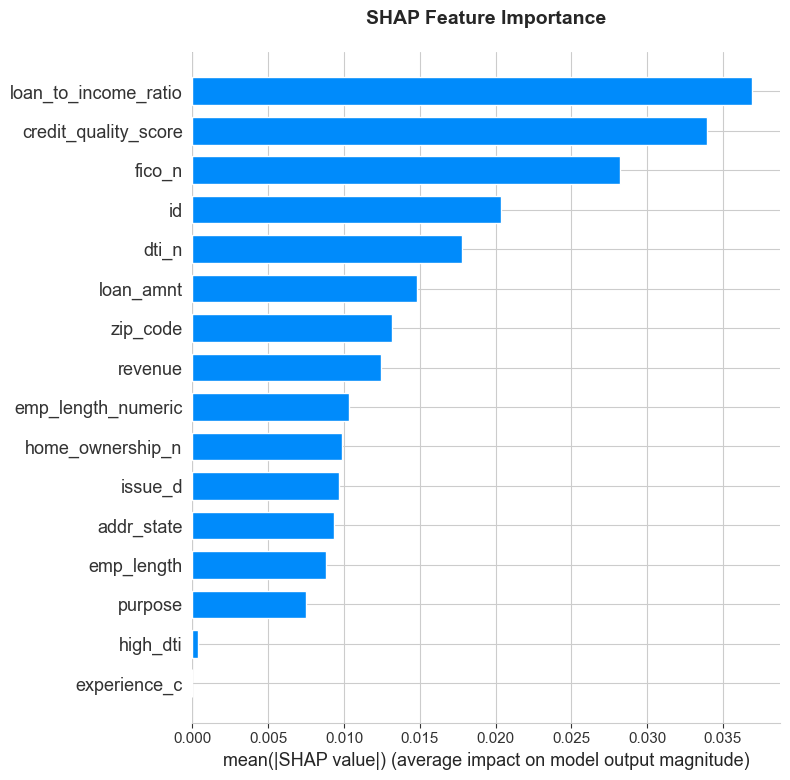

✅ SHAP importance plot saved


In [ ]:
# SHAP Summary Plot (Feature Importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("SHAP importance plot saved")

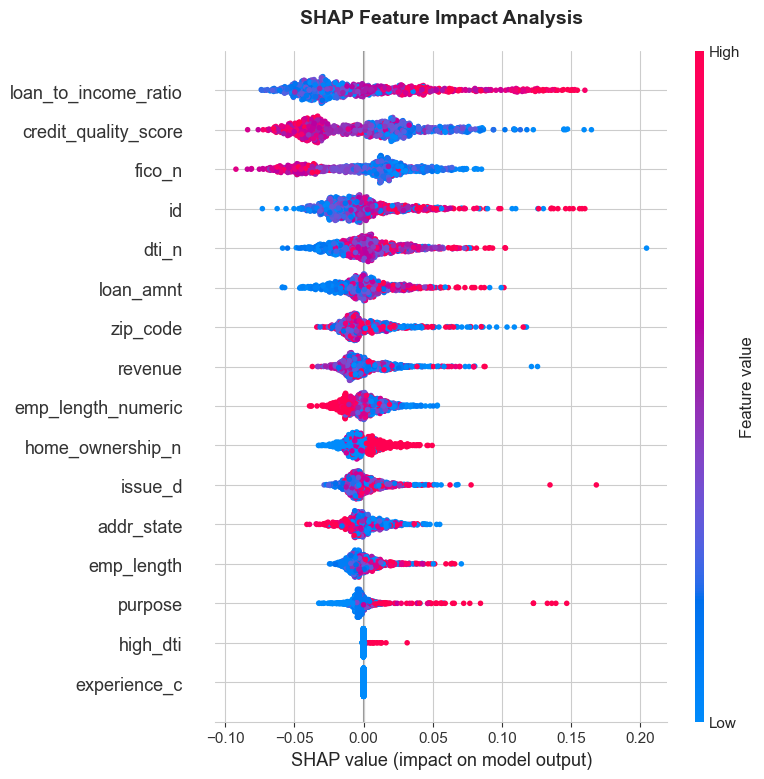

✅ SHAP summary plot saved


In [ ]:
# SHAP Summary Plot (Impact Direction)
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
plt.title('SHAP Feature Impact Analysis', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("SHAP summary plot saved")

Top 3 most important features: ['loan_to_income_ratio', 'credit_quality_score', 'fico_n']



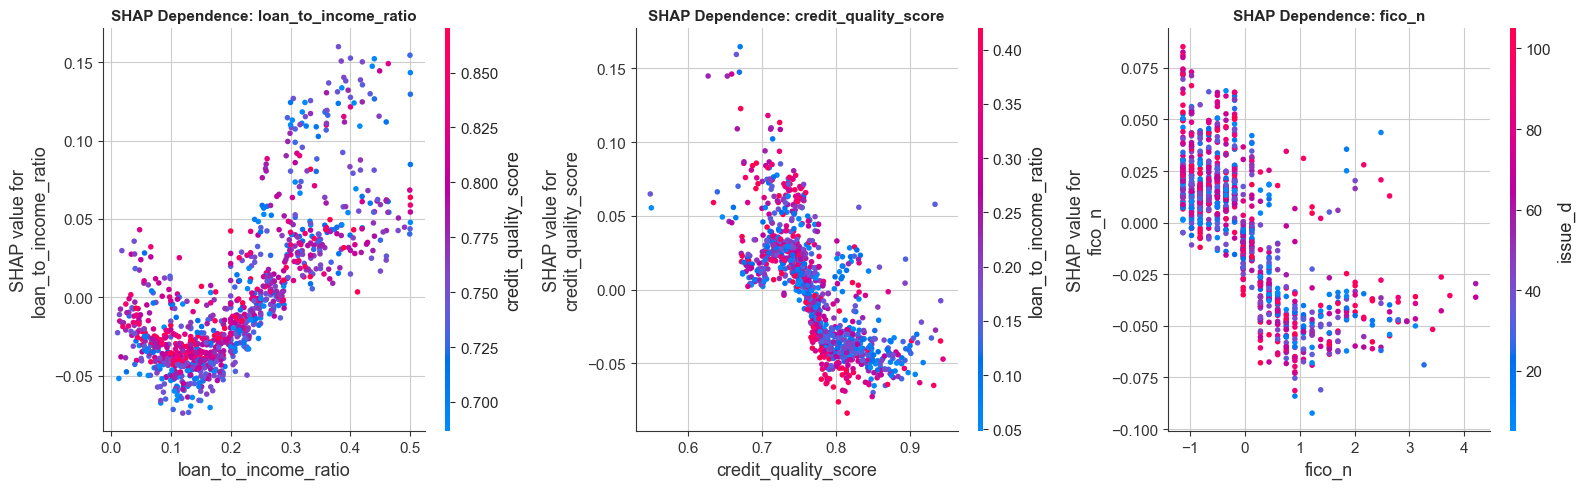

✅ SHAP dependence plots saved


In [ ]:
# SHAP Dependence Plots for top 3 features
# Get feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-3:][::-1]
top_features = [X_sample.columns[i] for i in top_features_idx]

print(f"Top 3 most important features: {top_features}\n")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for idx, (feat_idx, feat_name) in enumerate(zip(top_features_idx, top_features)):
    try:
        shap.dependence_plot(
            feat_idx, 
            shap_values, 
            X_sample,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feat_name}', fontweight='bold', fontsize=11)
    except Exception as e:
        print(f"Warning: Could not create dependence plot for {feat_name}: {e}")
        axes[idx].text(0.5, 0.5, f'Feature: {feat_name}\n(Plot unavailable)', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'SHAP Dependence: {feat_name}', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()
print("SHAP dependence plots saved")

## 5.1 Case Studies
We examine specific examples to understand system behavior: Correct High Confidence, Escalated High Uncertainty, and Dangerous High Confidence Errors.

In [30]:
# Prepare Case Study Data
results_df = pd.DataFrame({
    'True': y_test.values,
    'Pred': y_pred_test,
    'Prob': proba_test[:, 1],
    'Uncertainty': uncertainty_test,
    'Escalated': escalate_mask
})

# Add features (assuming X_test is DataFrame)
if isinstance(X_test, pd.DataFrame):
    results_df = pd.concat([results_df, X_test.reset_index(drop=True)], axis=1)

print("="*60)
print("CASE STUDY 1: HIGH UNCERTAINTY ESCALATED (System working as intended)")
print("="*60)
escalated_cases = results_df[results_df['Escalated']].sort_values('Uncertainty', ascending=False).head(3)
print(escalated_cases[['True', 'Pred', 'Prob', 'Uncertainty']].to_string())

print("\n" + "="*60)
print("CASE STUDY 2: HIGH CONFIDENCE ERROR (Dangerous 'Unknown Unknowns')")
print("="*60)
# Low uncertainty, but wrong prediction
mask_conf_error = (~results_df['Escalated']) & (results_df['True'] != results_df['Pred'])
dangerous_cases = results_df[mask_conf_error].sort_values('Uncertainty').head(3)
if len(dangerous_cases) > 0:
    print(dangerous_cases[['True', 'Pred', 'Prob', 'Uncertainty']].to_string())
else:
    print("No high confidence errors found! (Excellent result)")

print("\n" + "="*60)
print("CASE STUDY 3: HIGH CONFIDENCE CORRECT (Ideal Automation)")
print("="*60)
mask_conf_correct = (~results_df['Escalated']) & (results_df['True'] == results_df['Pred'])
ideal_cases = results_df[mask_conf_correct].sort_values('Uncertainty').head(3)
print(ideal_cases[['True', 'Pred', 'Prob', 'Uncertainty']].to_string())
print("="*60)

CASE STUDY 1: HIGH UNCERTAINTY ESCALATED (System working as intended)
       True  Pred      Prob  Uncertainty
32887     0     0  0.359550     0.151331
766       0     1  0.550143     0.135178
57770     1     1  0.551528     0.132832

CASE STUDY 2: HIGH CONFIDENCE ERROR (Dangerous 'Unknown Unknowns')
        True  Pred      Prob  Uncertainty
150808     0     1  0.831464     0.006354
78577      1     0  0.125078     0.007567
3166       0     1  0.840326     0.007679

CASE STUDY 3: HIGH CONFIDENCE CORRECT (Ideal Automation)
        True  Pred      Prob  Uncertainty
174697     0     0  0.011624     0.004430
151425     0     0  0.010973     0.004549
208564     0     0  0.012106     0.004685
